In [22]:
%clear

In [1]:
# hddm
import hddm
import kabuki
import pymc

# design matrix
from patsy import dmatrix

# data analysis
import pandas as pd
import numpy as np

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import ptitprince as pt

# parallel processing related
from p_tqdm import p_map
from functools import partial
from joblib import Parallel,delayed

# rmANOVA
from statsmodels.stats.anova import AnovaRM

# search file
import glob

# system
import os,sys,time

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = '/home/jovyan/work/scripts'
scripts_dir = '/home/jovyan/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from InferenceDataFromHDDM import InferenceDataFromHDDM
from plot_ppc_by_cond import plot_ppc_by_cond

In [3]:
print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current Kabuki version is', kabuki.__version__) # 0.6.4
print('The current PyMC version is', pymc.__version__) # 2.3.8
print('The current Numpy version is', np.__version__) 
print('The current Pandas version is', pd.__version__)
print('The current seaborn version is', sns.__version__)

The current HDDM version is 0.8.0
The current Kabuki version is 0.6.4
The current PyMC version is 2.3.8
The current Numpy version is 1.20.3
The current Pandas version is 1.3.5
The current seaborn version is 0.11.2


In [11]:
!pip install pandas


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


# Experiment Design

It is a car-face discrimination task in a 2* 2  factorial within-subject design. 

Experimental factors **"stimulus coherence”(with level "low" and "high")** and **"spatial prioritization"(with level "yes" and "no")**.

Experimental manipulation has four levels:




|level|coherence|prioritization|
| -------- | -------- | -------- |
|1|high|yes|
|2|high|no|
|3|low|yes|
|4|low|no|


![Image Name](https://cdn.kesci.com/upload/image/rmm71hlded.png?imageView2/0/w/960/h/960)


we assume that the effect of experimental design is reflected in underlying latent variable. 

Different levels corresponds to different parameters.

For the moment, we assume **phase coherence** can influence **drift rate(v)** and **spatial priotiziation** can influence **initial bias(z)**.

Because phase coherence have two levels(high & low) and spatial priotization(yes & no) have two levels, we have four levels together.

# Situation1

## Simulate data for the experiment

Because we need to code the response according to the stimulus, so we must transform the varibale 'stimulus'.

We assume that stimulus influence the parameter 'z'.

Due to the response is pressing 'car' or 'face', instead of accuracy coding, we set the stimulus(button press) as the boundaries.

So, when there are some bias, one stimulus is ``z``, another is ``1-z``.

In [24]:
# set the random seed
np.random.seed(123)

# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 20
trials_per_level = 72

# set up parameters of DDM for four levels of the stimulus face(1).
level1_a = {'v':.8, 'a':2, 't':.3, 'z':.8, 'sv':0, 'sz':0, 'st':0}
level2_a = {'v':.8, 'a':2, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level3_a = {'v':.2, 'a':2, 't':.3, 'z':.8, 'sv':0, 'sz':0, 'st':0}
level4_a = {'v':.2, 'a':2, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}

# set up parameters of DDM for four levels of the stimulus car(0).
level1_b = {'v':.8, 'a':2, 't':.3, 'z':.2, 'sv':0, 'sz':0, 'st':0}
level2_b = {'v':.8, 'a':2, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level3_b = {'v':.2, 'a':2, 't':.3, 'z':.2, 'sv':0, 'sz':0, 'st':0}
level4_b = {'v':.2, 'a':2, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}

# generate simulated data
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                             'level2':level2_a,
                                             'level3':level3_a,
                                             'level4':level4_a},
                                             size = trials_per_level,
                                             subjs = n_subjects)
data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                             'level2':level2_b,
                                             'level3':level3_b,
                                             'level4':level4_b},
                                             size = trials_per_level,
                                             subjs = n_subjects
)
# add column stimulus
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

# combine the data from two stimulus
data = data_a.append(data_b,ignore_index=True)

# add column coherence
data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0

## check the data

we can check how many trials per condition.

In [42]:
data.groupby(['subj_idx','stimulus','condition','coherence','attention']).size()

subj_idx  stimulus  condition  coherence  attention
0         0.0       level1     1.0        1.0          72
                    level2     1.0        0.0          72
                    level3     0.0        1.0          72
                    level4     0.0        0.0          72
          1.0       level1     1.0        1.0          72
                                                       ..
19        0.0       level4     0.0        0.0          72
          1.0       level1     1.0        1.0          72
                    level2     1.0        0.0          72
                    level3     0.0        1.0          72
                    level4     0.0        0.0          72
Length: 160, dtype: int64

In [43]:
data.groupby(['stimulus','coherence','attention','response'])['rt'].agg(['size','mean','std']).head(20)

size      mean       std
stimulus coherence attention response                          
0.0      0.0       0.0       0.0        494  1.197994  0.681693
                             1.0        946  1.233243  0.771780
                   1.0       0.0        974  0.793781  0.665234
                             1.0        466  1.475633  0.773954
         1.0       0.0       0.0        206  1.059652  0.532577
                             1.0       1234  1.066180  0.627825
                   1.0       0.0        667  0.689168  0.535394
                             1.0        773  1.356814  0.651742
1.0      0.0       0.0       0.0        631  1.181282  0.761018
                             1.0        809  1.206190  0.777833
                   1.0       0.0        234  1.398436  0.807061
                             1.0       1206  0.719062  0.569091
         1.0       0.0       0.0        281  1.109687  0.748369
                             1.0       1159  1.093177  0.639770
                   1.0       0.0         67  1.303904  0.690100
                             1.0       1373  0.662359  0.501304

In [44]:
data.groupby(['response'])['rt'].agg(['size','mean','std'])

,size,mean,std
response,,,
0.0,3554,0.988948,0.713071
1.0,7966,1.034168,0.699816


In [45]:
data.groupby(['stimulus','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus response                          
0.0      0.0       2341  0.872668  0.652656
         1.0       3419  1.233921  0.711226
1.0      0.0       1213  1.213361  0.769203
         1.0       4547  0.883969  0.652052

In [46]:
data.groupby(['coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
coherence response                          
0.0       0.0       2333  1.044824  0.743842
          1.0       3427  1.078870  0.761310
1.0       0.0       1221  0.882184  0.637038
          1.0       4539  1.000417  0.647587

In [47]:
data.groupby(['attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
attention response                          
0.0       0.0       1612  1.158380  0.710262
          1.0       4148  1.139131  0.700125
1.0       0.0       1942  0.848308  0.684412
          1.0       3818  0.920134  0.681485

we can check the effect of the coherence

In [48]:
data.groupby(['stimulus','coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherence response                          
0.0      0.0       0.0       1468  0.929804  0.697273
                   1.0       1412  1.313238  0.780596
         1.0       0.0        873  0.776591  0.557122
                   1.0       2007  1.178119  0.652501
1.0      0.0       0.0        865  1.240026  0.779272
                   1.0       2015  0.914638  0.702532
         1.0       0.0        348  1.147079  0.740528
                   1.0       2532  0.859562  0.607933

Also, we can check the effect of the attention

In [49]:
data.groupby(['stimulus','attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus attention response                          
0.0      0.0       0.0        700  1.157282  0.644141
                   1.0       2180  1.138676  0.698728
         1.0       0.0       1641  0.751260  0.617739
                   1.0       1239  1.401503  0.702271
1.0      0.0       0.0        912  1.159222  0.757455
                   1.0       1968  1.139634  0.701846
         1.0       0.0        301  1.377394  0.782434
                   1.0       2579  0.688875  0.534719

## anova

In [50]:
# ANOVA
model_aovrm3way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)


                          Anova
                             F Value Num DF  Den DF Pr > F
----------------------------------------------------------
coherence                    47.3861 1.0000 19.0000 0.0000
attention                    54.1370 1.0000 19.0000 0.0000
stimulus                      8.4608 1.0000 19.0000 0.0090
coherence:attention           8.8058 1.0000 19.0000 0.0079
coherence:stimulus            6.2351 1.0000 19.0000 0.0219
attention:stimulus           21.3151 1.0000 19.0000 0.0002
coherence:attention:stimulus 21.5495 1.0000 19.0000 0.0002



In [51]:
# ANOVA
model_aovrm3way = AnovaRM(data,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    403.5718 1.0000 19.0000 0.0000
attention                     39.0544 1.0000 19.0000 0.0000
stimulus                      43.6144 1.0000 19.0000 0.0000
coherence:attention           18.4459 1.0000 19.0000 0.0004
coherence:stimulus             1.5630 1.0000 19.0000 0.2264
attention:stimulus           599.2115 1.0000 19.0000 0.0000
coherence:attention:stimulus  21.0467 1.0000 19.0000 0.0002



The parameter **v** for high coherence is 0.8;

the parameter **v** for low coherence is 0.2;

the parameter **z** for cue of stimulus 1 is 0.8 and of stimulus 0 is 0.2;

the parameter **z** for no cue is 0.5;

At the same time, we assume that the response is mapping into two stimulus, car or face.

### model1 

v~coherence,

z~prioritization

when we fit the data, we will face the ideal situation.

$v=\alpha_0 + \alpha_1*C(coherence)$

$v_{low}=\alpha_0 = 0.2$

$v_{high}=\alpha_0 + \alpha_1 = 0.8$


$z=\beta_0 + \beta_1*C(prioritization)$ + z_link_func

stim = 1

$z_{no}=1 - \beta_0 = 0.5$

$z_{yes}=1 - (\beta_0 + \beta_1) = 0.2$

stim = 0

$z_{no}=\beta_0 = 0.5$

$z_{yes}=\beta_0 + \beta_1 = 0.8$

We expect the parameter estimated is:

$\alpha_0 = 0.2, \alpha_1 = 0.6$

$\beta_0 = 0.5, \beta_1 = 0.3$

### model2

if we set $v~C(coherence)*C(prioritization), z~C(coherence)*C(prioritization)$.

$v=\alpha_0 + \alpha_1*C(coherence) + \alpha_2*C(prioritization) + \alpha_3*C(coherence)*C(priorization)$

$v_{low,yes}=\alpha_0 + \alpha_2 + = 0.2$

$v_{high,yes}=\alpha_0 + \alpha_1 + \alpha_2 + \alpha_3= 0.8$

$v_{low,no}=\alpha_0  = 0.2$

$v_{high,no}=\alpha_0 + \alpha_1 = 0.8$

$v=\beta_0 + \beta_1*C(coherence) + \beta_2*C(prioritization) + \beta_3*C(coherence)*C(priorization)$ + z_link_func

stim = 1

$z_{no,high}=1 - \beta_0 - \beta_1= 0.5$

$z_{yes,high}=1 - (\beta_0 + \beta_1 + \beta_2 +\beta_3) = 0.2$

$z_{no,low}=1 - \beta_0 = 0.5$

$z_{yes,low}=1 - (\beta_0 + \beta_2) = 0.2$

stim = 0

$z_{no,high}=\beta_0 + \beta_1 = 0.5$

$z_{yes,high}=\beta_0 + \beta_1 + \beta_2 + \beta_3 = 0.8$

$z_{no,low}=\beta_0 = 0.5$

$z_{yes,low}=\beta_0 + \beta_2 = 0.8$

We expect the parameter estimated is:

$\alpha_0 = 0.2, \alpha_1 = 0.6, \alpha_2 = 0, \alpha_3 = 0$

$\beta_0 = 0.5, \beta_2 = 0.3, \beta_1 = 0, \beta_3 = 0$

this is the link func. the function is to create the node of z,

for stimulus 0, the node of z is $\beta_0 + \beta_1*X$

for stimulus 1, the node of z is $1 - (\beta_0 + \beta_1*X)$

In [19]:
def z_link_func(x, data=data):
    stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                              {'s': data.stimulus.loc[x.index]},return_type='dataframe'))
    )
    # Apply z = (1 - x) to flip them along 0.5
    z_flip = np.subtract(stim, x.to_frame())
    # The above inverts those values we do not want to flip,
    # so invert them back
    z_flip[stim == 0] *= -1
    return z_flip

## Fit data

### model1 

In [20]:
v_reg = {'model':'v~C(coherence)','link_func':lambda x:x}
z_reg = {'model':'z~C(attention)','link_func':z_link_func}
reg_descr = [v_reg, z_reg]
m_reg = hddm.HDDMRegressor(data, reg_descr, include='z')

Adding these covariates:
['v_Intercept', 'v_C(coherence)[T.1.0]']
Adding these covariates:
['z_Intercept', 'z_C(attention)[T.1.0]']


because we construct a glm, so we can check the design matrix and parameters.

this is the parameters.

In [55]:
# hddm/models/hddm_regression.py/line 164
params=np.matrix(m_reg.model_descrs[1]['params'])
params

matrix([['z_Intercept', 'z_C(attention)[T.1.0]']], dtype='<U21')

this is the design matrixs.

In [56]:
# hddm/models/hddm_regression.py/line 154
design_matrix=dmatrix('C(attention)',
                data,
                return_type="dataframe",
                NA_action="raise")
design_matrix

,Intercept,C(attention)[T.1.0]
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
11515,1.0,0.0
11516,1.0,0.0
11517,1.0,0.0
11518,1.0,0.0


` hddm/models/hddm_regression.py/line 174`

`design_matrix.dot(params.T)`

the row and line is nx2 2x1

the result is $\beta_0 + \beta_1 * C(attention)$

Then the linear predictor need to be transformed via link function

```
def z_link_func(x, data=data):
    stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                              {'s': data.stimulus.loc[x.index]},return_type='dataframe'))
    )
    # Apply z = (1 - x) to flip them along 0.5
    z_flip = np.subtract(stim, x.to_frame())
    # The above inverts those values we do not want to flip,
    # so invert them back
    z_flip[stim == 0] *= -1
    return z_flip
```

In [57]:
np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                              {'s': data.stimulus.loc[data.index]},return_type='dataframe'))

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

for stimulus 0, the result is $\beta_0 + \beta_1*X$

for stimulus 1, the result is $1 - (\beta_0 + \beta_1*X)$

In [13]:
v_reg = {'model':'v~C(coherence)','link_func':lambda x:x}
z_reg = {'model':'z~C(attention)','link_func':lambda x:x}
reg_descr = [v_reg, z_reg]
m_reg = hddm.HDDMRegressor(data, reg_descr, include='z')
m_reg.find_starting_values()
m_reg.sample(2000,burn=1000)

Adding these covariates:
['v_Intercept', 'v_C(coherence)[T.1.0]']
Adding these covariates:
['z_Intercept', 'z_C(attention)[T.1.0]']


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Process ForkPoolWorker-14:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-15:
Process ForkPoolWorker-16:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-10:
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    se

  File "/opt/conda/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
  File

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/pytho

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py", line 1030, in _partial_optimize
    minimize(opt, init_vals, method=minimizer, options=minimizer_kwargs)
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 614, in minimize
    return _minimize_powell(fun, x0, args, callback, bounds, **options)
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py", line 3031, in _minimize_powell
    fval, x, direc1 = _linesearch_powell(func, x, direc1,
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py", line 2762, in _linesearch_powell
    alpha_min, fret, _, _ = brent(myfunc, full_output=1, tol=tol)
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py", line 2364, in brent
    res = _minimize_scalar_brent(func, brack, args, **options)
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py", line 2396, in _minimize_scalar_brent
    b

  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
Keyboard

TypeError: object of type 'NoneType' has no len()

In [ ]:
m_reg.plot_posteriors()

### model2

the glm and link function is similiar to model1.

In [40]:
v_reg = {'model':'v~C(coherence)*C(attention)','link_func':lambda x:x}
z_reg = {'model':'z~C(coherence)*C(attention)','link_func':z_link_func}
reg_descr = [v_reg, z_reg]
m_reg2 = hddm.HDDMRegressor(data, reg_descr, include='z')
m_reg2.find_starting_values()
m_reg2.sample(2000,burn=1000)

NameError: name 'z_link_func' is not defined

In [ ]:
m_reg2.plot_posteriors()

### model3

In model3, we want to test if we use incorrect coding, the results of the model.

In [25]:
data_tmp = data
data_tmp.loc[(data_tmp['response']==1)&(data_tmp['stimulus']==0),'_response'] = 0 
data_tmp.loc[(data_tmp['response']==1)&(data_tmp['stimulus']==1),'_response'] = 1 
data_tmp.loc[(data_tmp['response']==0)&(data_tmp['stimulus']==0),'_response'] = 1
data_tmp.loc[(data_tmp['response']==0)&(data_tmp['stimulus']==1),'_response'] = 0
data_tmp['response'] = data_tmp['_response']

In [26]:
data_tmp

,rt,response,subj_idx,condition,stimulus,coherence,attention,_response
0,0.803506,1.0,14.0,level1,1.0,1.0,1.0,1.0
1,0.690506,1.0,14.0,level1,1.0,1.0,1.0,1.0
2,0.678506,1.0,14.0,level1,1.0,1.0,1.0,1.0
3,0.753506,1.0,14.0,level1,1.0,1.0,1.0,1.0
4,0.813506,1.0,14.0,level1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
283,0.851019,0.0,14.0,level4,0.0,0.0,0.0,0.0
284,0.500019,0.0,14.0,level4,0.0,0.0,0.0,0.0
285,0.799019,0.0,14.0,level4,0.0,0.0,0.0,0.0
286,1.246019,0.0,14.0,level4,0.0,0.0,0.0,0.0


we can check how many trials per condition.

In [ ]:
data_tmp.groupby(['subj_idx','stimulus','condition','coherence','attention']).size()

In [ ]:
data_tmp.groupby(['stimulus','coherence','attention','response'])['rt'].agg(['size','mean','std']).head(20)

In [ ]:
data_tmp.groupby(['response'])['rt'].agg(['size','mean','std'])

In [ ]:
data_tmp.groupby(['stimulus','response'])['rt'].agg(['size','mean','std'])

we can check the effect of the coherence

In [ ]:
data_tmp.groupby(['stimulus','coherence','response'])['rt'].agg(['size','mean','std'])

Also, we can check the effect of the attention

In [ ]:
data_tmp.groupby(['stimulus','attention','response'])['rt'].agg(['size','mean','std'])

In [ ]:
v_reg = {'model':'v~C(coherence)','link_func':lambda x:x}
z_reg = {'model':'z~C(attention)','link_func':z_link_func}
reg_descr = [v_reg, z_reg]
m_reg3 = hddm.HDDMRegressor(data_tmp, reg_descr, include='z')
m_reg3.find_starting_values()
m_reg3.sample(2000,burn=1000)

In [ ]:
m_reg3.plot_posteriors()

# Simulation2

## simulate the data

To advance the simulated data similar to our true data, we adjust the value of parameter, and construct the hierarchical structure of every subjects.

In this part, we assume that the prioritization affect the non-decision time

In [6]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 15
trials_per_level = 36

# set the group parameter
# intercept and slope of v
v_int = 1
v_coh = 0.5
v_sig1 = 0.2
v_sig2 = 0.1
# intercept and slope of t
t_int = 0.3
t_pri = 0.2
t_sig1 = 0.1
t_sig2 = 0.1
# intercept of a
a_int = 1.4
a_sig = 0.1
# intercept of z
z_int = 0.5
z_sig = 0.1

# set the subject parameter
# v
v_int_subj = np.random.normal(v_int,v_sig1,[n_subjects,2])
v_coh_subj = np.random.normal(v_coh,v_sig2,[n_subjects,2])
# t
t_int_subj = np.random.normal(t_int,t_sig1,[n_subjects,2])
t_pri_subj = np.random.normal(t_pri,t_sig2,[n_subjects,2])
# a
a_int_subj = np.random.normal(a_int,a_sig,[n_subjects,2])
# z
z_int_subj = np.random.normal(z_int,z_sig,[n_subjects,2])

# dataframe
df = pd.DataFrame()
for i in range(n_subjects):
    # the different v of two experimental factor 
    v_high  = v_int_subj[i] + v_coh_subj[i]
    v_low = v_int_subj[i]
    # the different t of two experimental factor
    t_yes = t_int_subj[i] + t_pri_subj[i]
    t_no = t_int_subj[i]
    # the default parameter a
    a = a_int_subj[i]
    # the default parameter z
    z = z_int_subj[i]
    # set up parameters of DDM for four levels of the stimulus face(1).
    level1_a = {'v':v_high[0], 'a':a[0], 't':t_yes[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level2_a = {'v':v_high[0], 'a':a[0], 't':t_no[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level3_a = {'v':v_low[0], 'a':a[0], 't':t_yes[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level4_a = {'v':v_low[0], 'a':a[0], 't':t_no[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}

    # set up parameters of DDM for four levels of the stimulus car(0).
    level1_b = {'v':v_high[1], 'a':a[1], 't':t_yes[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level2_b = {'v':v_high[1], 'a':a[1], 't':t_no[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level3_b = {'v':v_low[1], 'a':a[1], 't':t_yes[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level4_b = {'v':v_low[1], 'a':a[1], 't':t_no[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}

    # generate simulated data
    np.random.seed(123)
    data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                                 'level2':level2_a,
                                                 'level3':level3_a,
                                                 'level4':level4_a},
                                                 size = trials_per_level
                                                  )
    data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                                 'level2':level2_b,
                                                 'level3':level3_b,
                                                 'level4':level4_b},
                                                 size = trials_per_level
                                                 )
    # add column stimulus
    data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
    data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

    # combine the data from two stimulus
    data = data_a.append(data_b,ignore_index=True)
    
    # add subject
    data['subj_idx'] = pd.Series(np.ones((len(data)))*i, index=data.index).astype('int64')

    # add column coherence
    data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
    data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

    # add column spatial priotiziation
    data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
    data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0
    
    df = df.append(data)

In [35]:
# set the random seed
np.random.seed(123)

# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 15
trials_per_level = 36

# set up parameters of DDM for four levels of the stimulus face(1).
level1_a = {'v':1, 'a':1.4, 't':.1, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level2_a = {'v':1, 'a':1.4, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level3_a = {'v':0.5, 'a':1.4, 't':.1, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level4_a = {'v':0.5, 'a':1.4, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}

# set up parameters of DDM for four levels of the stimulus car(0).
level1_b = {'v':1, 'a':1.4, 't':.1, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level2_b = {'v':1, 'a':1.4, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level3_b = {'v':0.5, 'a':1.4, 't':.1, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level4_b = {'v':0.5, 'a':1.4, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}

# generate simulated data
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                             'level2':level2_a,
                                             'level3':level3_a,
                                             'level4':level4_a},
                                             size = trials_per_level,
                                             subjs = n_subjects)
data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                             'level2':level2_b,
                                             'level3':level3_b,
                                             'level4':level4_b},
                                             size = trials_per_level,
                                             subjs = n_subjects
)
# add column stimulus
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

# combine the data from two stimulus
data = data_a.append(data_b,ignore_index=True)

# add column coherence
data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0

In [36]:
df=data

In [37]:
# the stimulus coding
df.loc[(df['stimulus']==0)&(df['response']==0),'_response']=1
df.loc[(df['stimulus']==1)&(df['response']==1),'_response']=1
df.loc[(df['stimulus']==0)&(df['response']==1),'_response']=0
df.loc[(df['stimulus']==1)&(df['response']==0),'_response']=0

In [38]:
df

,rt,response,subj_idx,condition,stimulus,coherence,attention,_response
0,0.376668,0.0,0,level1,1.0,1.0,1.0,0.0
1,0.380019,0.0,0,level1,1.0,1.0,1.0,0.0
2,0.417848,1.0,0,level1,1.0,1.0,1.0,1.0
3,0.412085,1.0,0,level1,1.0,1.0,1.0,1.0
4,0.537923,1.0,0,level1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
4315,1.076725,1.0,14,level4,0.0,0.0,0.0,0.0
4316,0.869217,1.0,14,level4,0.0,0.0,0.0,0.0
4317,1.451146,1.0,14,level4,0.0,0.0,0.0,0.0
4318,0.781686,1.0,14,level4,0.0,0.0,0.0,0.0


## check the data

In [39]:
df.groupby(['response'])['rt'].agg(['size','mean','std'])

,size,mean,std
response,,,
0.0,1231,0.667187,0.403321
1.0,3089,0.680002,0.382078


In [40]:
df.groupby(['_response'])['rt'].agg(['size','mean','std'])

,size,mean,std
_response,,,
0.0,2263,0.681999,0.394477
1.0,2057,0.670137,0.381272


In [41]:
df.groupby(['stimulus','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus response                          
0.0      0.0        564  0.668456  0.384916
         1.0       1596  0.688637  0.383917
1.0      0.0        667  0.666115  0.418536
         1.0       1493  0.670772  0.380014

In [42]:
df.groupby(['coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
coherence response                          
0.0       0.0        787  0.697991  0.424620
          1.0       1373  0.710246  0.408856
1.0       0.0        444  0.612588  0.356472
          1.0       1716  0.655804  0.357501

In [43]:
df.groupby(['attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
attention response                          
0.0       0.0        626  0.768612  0.406970
          1.0       1534  0.779456  0.363127
1.0       0.0        605  0.562243  0.371731
          1.0       1555  0.581892  0.374985

In [44]:
df.groupby(['stimulus','coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherence response                          
0.0      0.0       0.0        378  0.700725  0.409626
                   1.0        702  0.714153  0.414863
         1.0       0.0        186  0.602878  0.320159
                   1.0        894  0.668601  0.356707
1.0      0.0       0.0        409  0.695464  0.438509
                   1.0        671  0.706159  0.402744
         1.0       0.0        258  0.619588  0.380967
                   1.0        822  0.641886  0.358061

In [45]:
df.groupby(['stimulus','attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus attention response                          
0.0      0.0       0.0        286  0.774402  0.396410
                   1.0        794  0.792146  0.363331
         1.0       0.0        278  0.559462  0.340505
                   1.0        802  0.586160  0.376392
1.0      0.0       0.0        340  0.763741  0.416165
                   1.0        740  0.765840  0.362659
         1.0       0.0        327  0.564607  0.396854
                   1.0        753  0.577346  0.373677

In [46]:
df.groupby(['stimulus','coherence','attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherence attention response                          
0.0      0.0       0.0       0.0        198  0.801801  0.426993
                             1.0        342  0.807887  0.405101
                   1.0       0.0        180  0.589541  0.359176
                             1.0        360  0.625105  0.404811
         1.0       0.0       0.0         88  0.712754  0.310440
                             1.0        452  0.780237  0.328181
                   1.0       0.0         98  0.504215  0.297099
                             1.0        442  0.554440  0.348816
1.0      0.0       0.0       0.0        208  0.782039  0.436345
                             1.0        332  0.800485  0.379183
                   1.0       0.0        201  0.605873  0.423496
                             1.0        339  0.613780  0.404260
         1.0       0.0       0.0        132  0.734908  0.382048
                             1.0        408  0.737648  0.346555
                   1.0       0.0        126  0.498778  0.341581
                             1.0        414  0.547512  0.344267

## visualize the data

### the barplot

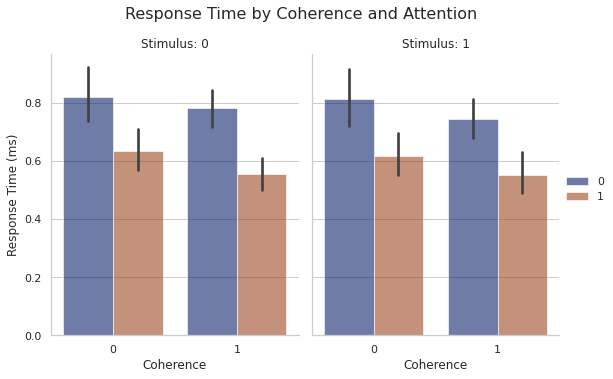

In [47]:
# get the mean of accurate RTs
data_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the figure theme
sns.set_theme(style="whitegrid")
# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

### the raincloud plot 

Text(0.5, 1, 'Response Time by Coherence and Attention')

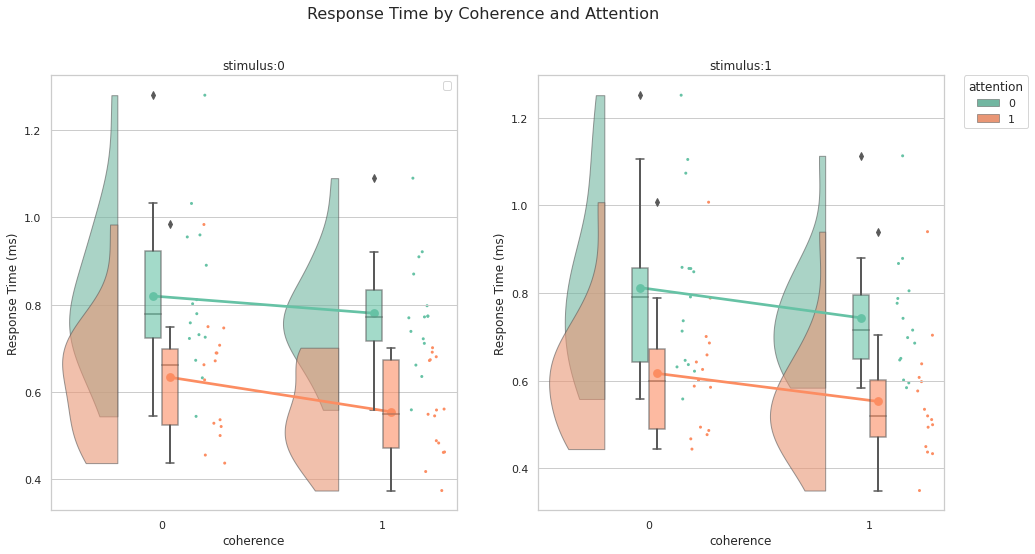

In [48]:
f, ax = plt.subplots(1,2,figsize=(16, 8))
# the left figure
ax[0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0].legend('')
ax[0].set_title('stimulus:0')
ax[0].set_ylabel('Response Time (ms)')
# the right figure
ax[1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1].set_title('stimulus:1')
ax[1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

## ANOVA

In [49]:
# ANOVA for rt
model_aovrm3way = AnovaRM(df,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(df,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                     26.7955 1.0000 14.0000 0.0001
attention                    324.6948 1.0000 14.0000 0.0000
stimulus                       0.1308 1.0000 14.0000 0.7230
coherence:attention            1.7430 1.0000 14.0000 0.2079
coherence:stimulus             0.2092 1.0000 14.0000 0.6544
attention:stimulus             0.4069 1.0000 14.0000 0.5338
coherence:attention:stimulus   0.1503 1.0000 14.0000 0.7040

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    124.2521 1.0000 14.0000 0.0000
attention                      1.1017 1.0000 14.0000 0.3117
stimulus                       2.4223 1.0000 14.0000 0.1419
coherence:attention            1.2682 1.0000 14.0000 0.2790
coherence:stimulus             1.

## fit data

### define the model

In [7]:
def z_link_func(x, data=df):
        stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                                  {'s': data.stimulus.loc[x.index]},return_type='dataframe'))
        )
        # Apply z = (1 - x) to flip them along 0.5
        z_flip = np.subtract(stim, x.to_frame())
        # The above inverts those values we do not want to flip,
        # so invert them back
        z_flip[stim == 0] *= -1
        return z_flip

In [50]:
 def ms1(id, df=None, samples=None, burn=None, thin=1,save_name='ms1'):
    '''
    id: the id of cpu thread
    df: the input data
    samples: number of samples for MCMC
    burn: number of burn-in of MCMC
    thin: number of thin
    save_name: prefix of file name when saving the model object
    '''
    print('running chain {:d} for model {}'.format(id, save_name))
    # the database file
    dbname = save_name + '_chain_%i.db'%id
    # the model object store here
    mname = save_name + '_chain_%i'%id
    # define the model
    v_reg = {'model':'v~C(coherence)','link_func':lambda x:x}
    t_reg = {'model':'t~C(attention)','link_func':lambda x:x}
    reg_descr = [v_reg, t_reg]
    m = hddm.HDDMRegressor(df, 
                           reg_descr, 
                           include='z',
                           group_only_regressors=False,
                           keep_regressor_trace=True
                          )
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save
    m.save(mname)

    return m

### judge whether need to sample

In [3]:
%%time
# number of chains
chains=4
# file name
file_names = glob.glob('ms1'+'_chain_*[!db]',recursive=False)
# if there exists file, pass
if file_names:
    # sort filename by id
    file_names = sorted(file_names, key = lambda x:x[-1])
    ms1res = []
    for fname in file_names:
        print('current loading:',fname,'\n')
        ms1res.append(hddm.load(fname))
# else sample
else:
    ms1res = Parallel(n_jobs = 4)(delayed(ms1)(id = i, df = df, samples=2000,burn = 1000,thin=1, save_name = 'ms1' ) for i in range(4))

current loading: ms1_chain_0 

current loading: ms1_chain_1 

current loading: ms1_chain_2 

current loading: ms1_chain_3 

CPU times: user 41.2 s, sys: 8.27 s, total: 49.5 s
Wall time: 49.7 s


In [51]:
ms1res = Parallel(n_jobs = 4)(delayed(ms1)(id = i, df = df, samples=4000,burn = 2000,thin=2, save_name = 'ms1' ) for i in range(4))

### convert hddm model object to Inferencedata    

In [54]:
%%time
InfData_ms1 = InferenceDataFromHDDM(ms1res, nppc = 300, save_name="infdata_ms1")

start converting infdata_ms1


  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       26%                  ] 4 of 15 complete in 188.0 sec[----------       26%                  ] 4 of 15 complete in 190.1 sec[----------       26%                  ] 4 of 15 complete in 191.2 sec[----------       26%                  ] 4 of 15 complete in 192.1 sec[------------     33%                  ] 5 of 15 complete in 372.1 sec[------------     33%                  ] 5 of 15 complete in 377.1 sec[------------     33%                  ] 5 of 15 complete in 378.2 sec[------------     33%                  ] 5 of 15 complete in 380.4 sec[---------------  40%                  ] 6 of 15 complete in 562.9 sec[---------------  40%                  ] 6 of 15 complete in 570.5 sec[---------------  40%                  ] 6 of 15 complete in 572.4 sec[---------------  40%                  ] 6 of 15 complete in 

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       26%                  ] 4 of 15 complete in 42.0 sec[----------       26%                  ] 4 of 15 complete in 42.2 sec[----------       26%                  ] 4 of 15 complete in 43.1 sec[----------       26%                  ] 4 of 15 complete in 43.3 sec[------------     33%                  ] 5 of 15 complete in 83.8 sec[------------     33%                  ] 5 of 15 complete in 84.6 sec[------------     33%                  ] 5 of 15 complete in 86.1 sec[------------     33%                  ] 5 of 15 complete in 86.3 sec[---------------  40%                  ] 6 of 15 complete in 124.6 sec[---------------  40%                  ] 6 of 15 complete in 125.6 sec[---------------  40%                  ] 6 of 15 complete in 127.6 sec[---------------  40%                  ] 6 of 15 complete in 128.0 se

In [ ]:
%%time
file_names = glob.glob('infdata_ms1_netcdf',recursive=False)
if file_names:
    infdata_ms1 = az.from_netcdf('infdata_ms1_netcdf')
else:
    InfData_ms1 = InferenceDataFromHDDM(ms1res, nppc = 300, save_name="infdata_ms1")

## visualization

### plot traces

Plotting a
Plotting a_std
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(coherence)[T.1.0]
Plotting v_C(coherence)[T.1.0]_std
Plotting t_Intercept
Plotting t_Intercept_std
Plotting t_C(attention)[T.1.0]
Plotting t_C(attention)[T.1.0]_std


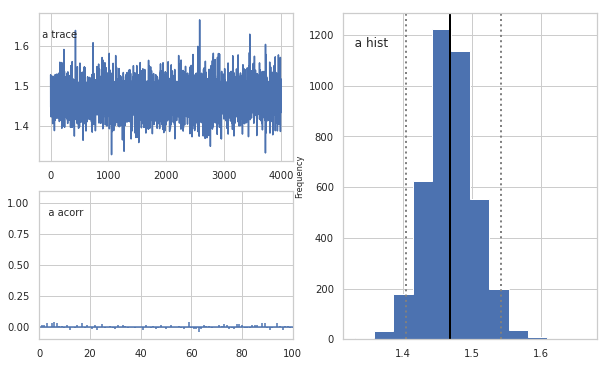

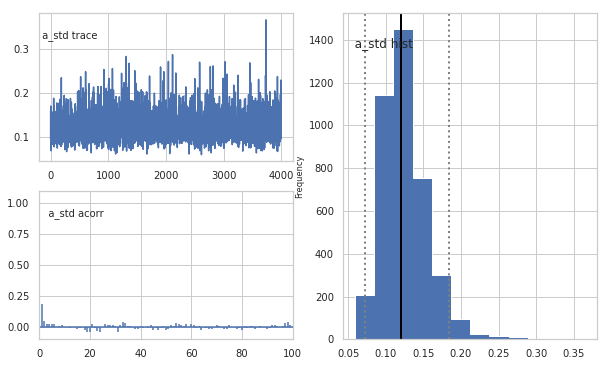

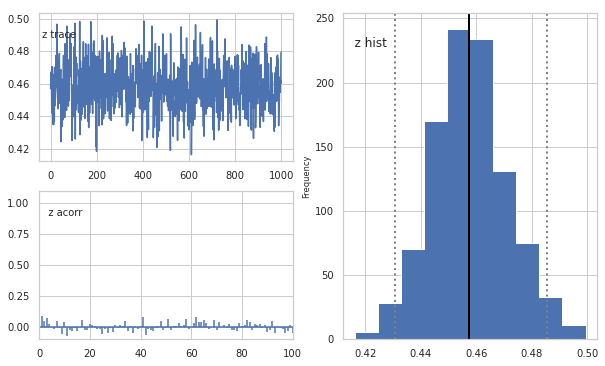

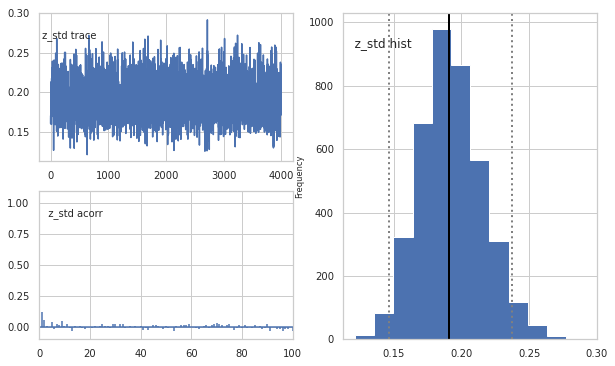

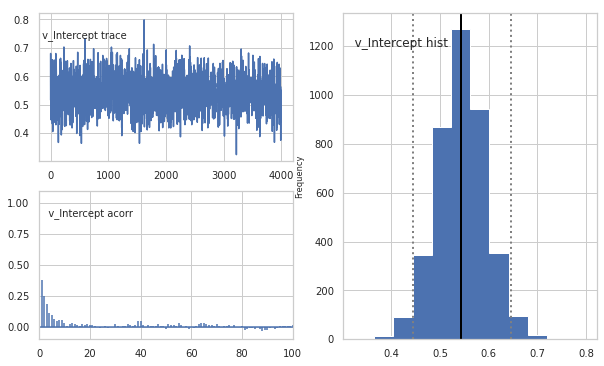

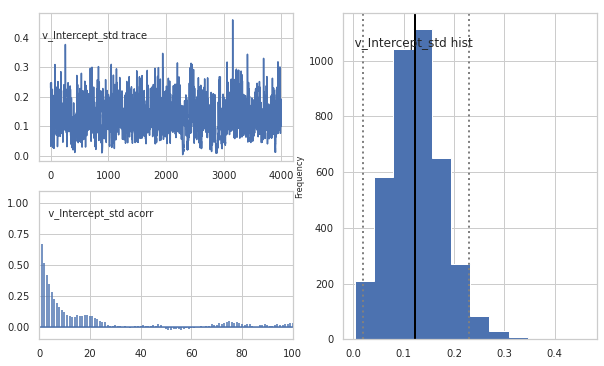

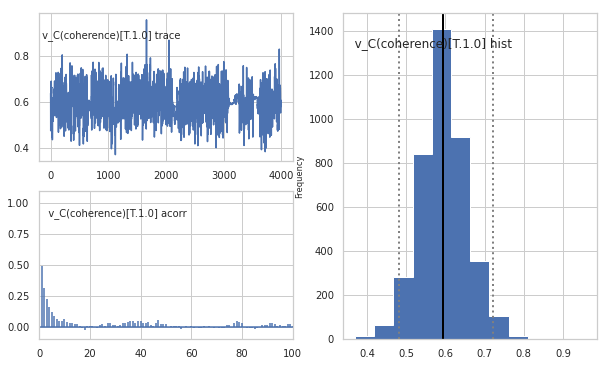

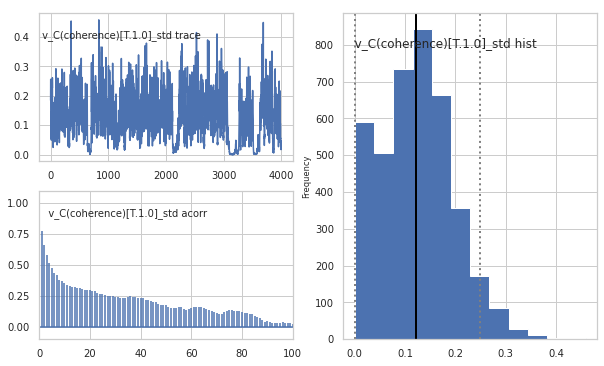

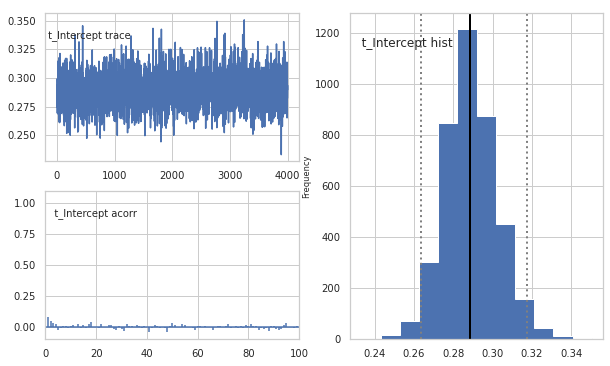

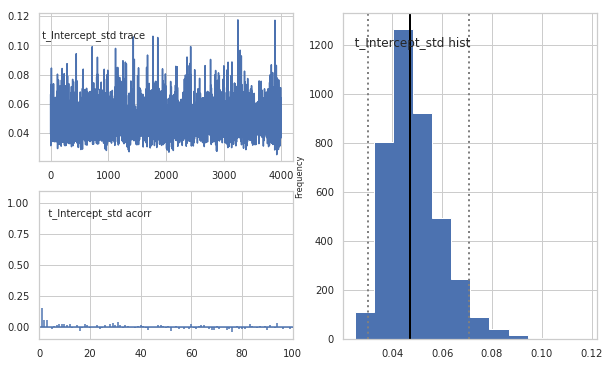

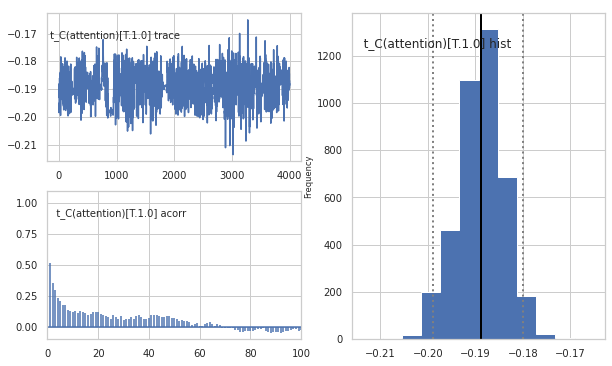

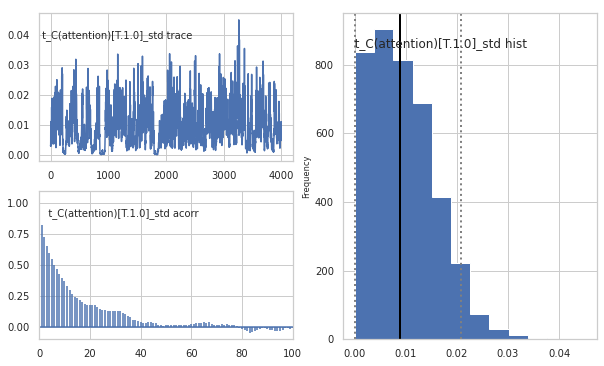

In [52]:
m1 = kabuki.utils.concat_models(ms1res)
m1.plot_posteriors()

array([[<AxesSubplot:title={'center':'v_Intercept'}>,
        <AxesSubplot:title={'center':'v_Intercept'}>],
       [<AxesSubplot:title={'center':'v_C(coherence)[T.1.0]'}>,
        <AxesSubplot:title={'center':'v_C(coherence)[T.1.0]'}>]],
      dtype=object)

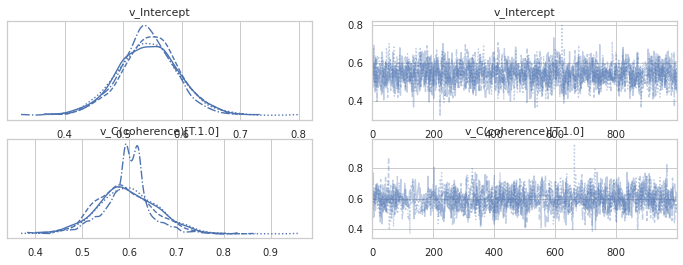

In [55]:
az.plot_trace(InfData_ms1, var_names=("^v(?!.*(subj|std))"), filter_vars='regex')

array([[<AxesSubplot:title={'center':'t_Intercept'}>,
        <AxesSubplot:title={'center':'t_Intercept'}>],
       [<AxesSubplot:title={'center':'t_C(attention)[T.1.0]'}>,
        <AxesSubplot:title={'center':'t_C(attention)[T.1.0]'}>]],
      dtype=object)

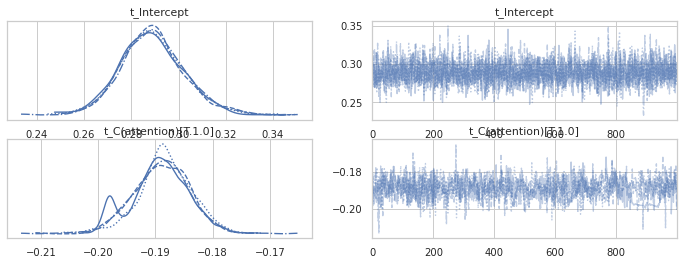

In [56]:
az.plot_trace(InfData_ms1, var_names=("^t(?!.*(subj|std))"), filter_vars='regex')

### summary data

In [57]:
ms1_summary_tmp = az.summary(InfData_ms1, round_to=4)
ms1_summary_tmp.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_std,0.1925,0.0234,0.1494,0.2366,0.0004,0.0003,2704.1186,3615.8383,0.9995
a_subj.1,1.5480,0.0477,1.4586,1.6374,0.0009,0.0006,3056.1937,3243.1333,0.9997
a_subj.3,1.3919,0.0443,1.3141,1.4804,0.0008,0.0006,3157.8874,3362.2784,0.9998
z_subj_trans.13,-0.2783,0.0722,-0.4187,-0.1466,0.0012,0.0009,3444.3667,3546.3864,0.9998
z_subj_trans.10,-0.2539,0.0753,-0.3970,-0.1112,0.0013,0.0009,3466.2972,3701.8316,0.9998
...,...,...,...,...,...,...,...,...,...
v_C(coherence)[T.1.0],0.5943,0.0597,0.4915,0.7213,0.0020,0.0014,815.8411,1549.8033,1.0236
v_C(coherence)[T.1.0]_subj.5,0.6334,0.1061,0.4510,0.8562,0.0033,0.0024,1062.7190,2616.2663,1.0243
v_C(coherence)[T.1.0]_subj.12,0.4398,0.1389,0.1703,0.6499,0.0104,0.0081,155.2568,1825.1117,1.0298
t_C(attention)[T.1.0]_std,0.0096,0.0063,0.0001,0.0202,0.0005,0.0003,130.5569,83.0915,1.0366


In [14]:
m1.print_stats()

                                   mean       std      2.5q       25q       50q       75q     97.5q    mc err
a                              1.463763  0.020532  1.425512  1.450005  1.463586  1.476693  1.504975  0.000383
a_std                          0.061126  0.021248  0.024517  0.046284  0.059273  0.073091  0.110648  0.000611
a_subj.0                       1.421592  0.036434  1.347591  1.397032  1.421992  1.447561  1.490014  0.000828
a_subj.1                       1.446273  0.036237  1.376247  1.422235  1.446804  1.470109  1.518063  0.000595
a_subj.2                       1.552191   0.04605  1.467325  1.520348  1.550131  1.582748  1.648334  0.001158
a_subj.3                        1.46621  0.036757  1.395999   1.44192   1.46519  1.490117  1.542298  0.000632
a_subj.4                       1.477252  0.037367  1.408232  1.451173  1.476709    1.5016  1.552198  0.000677
a_subj.5                       1.482503  0.039923  1.408376  1.455913  1.481081  1.508683  1.563764  0.000831
a_subj.6  

### posterior predictive check

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

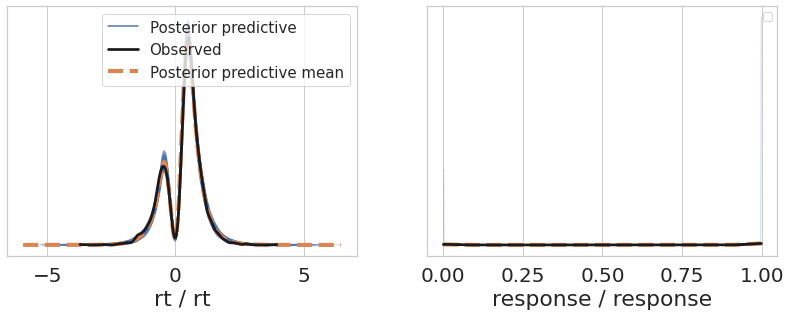

In [58]:
az.plot_ppc(InfData_ms1,
            var_names=['rt','response'], 
            textsize=20, 
            num_pp_samples=300, 
            alpha = 0.2)

### Check dic, loo and waic

In [59]:
# dic
m1.dic

6244.512471582743

In [60]:
# loo
az.loo(InfData_ms1, scale="deviance")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 4000 by 4320 log-likelihood matrix

             Estimate       SE
deviance_loo 14343.40  2538.70
p_loo         4047.35        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4278   99.0%
 (0.5, 0.7]   (ok)         13    0.3%
   (0.7, 1]   (bad)         7    0.2%
   (1, Inf)   (very bad)   22    0.5%

In [61]:
# waic
az.waic(InfData_ms1, scale="deviance")

Computed from 4000 by 4320 log-likelihood matrix

              Estimate       SE
deviance_waic 35791.64  10601.25
p_waic        14771.47        -

There has been a warning during the calculation. Please check the results.

### posterior predictive check by condition

[3, 1.0]
[3, 0.0]


array([[<AxesSubplot:xlabel='rt / rt\nsubj_3, coherence_1.0'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, coherence_0.0'>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

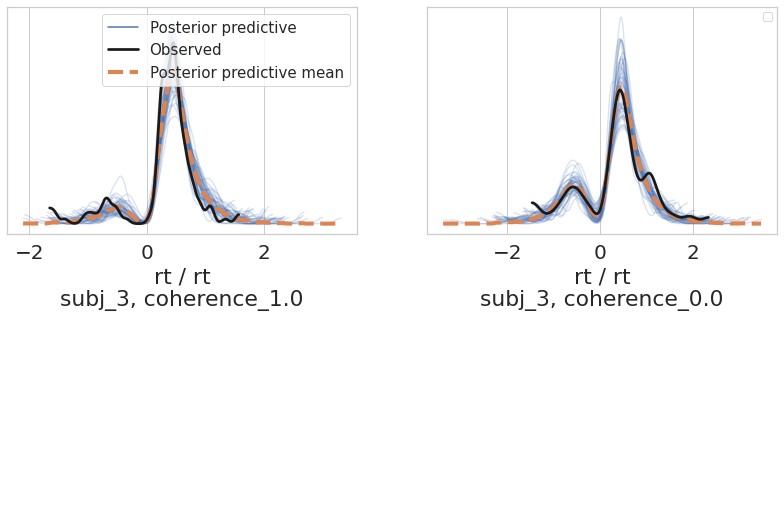

In [62]:
# coherence
plot_ppc_by_cond(data = InfData_ms1, 
                 or_d = df, 
                 subjs = [3], 
                 conds = ['coherence'], 
                 num_pp_samples=300, 
                 random_seed = 7, 
                 alpha = 0.2, 
                 grid = [2,2], 
                 textsize=20, 
                 var_names=['rt'])

[3, 1.0]
[3, 0.0]


array([[<AxesSubplot:xlabel='rt / rt\nsubj_3, attention_1.0'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, attention_0.0'>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

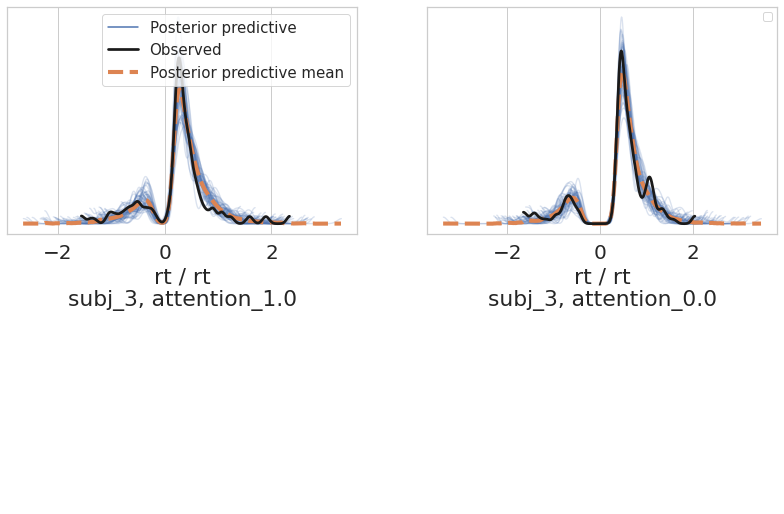

In [63]:
# attention
plot_ppc_by_cond(data = InfData_ms1, 
                 or_d = df, 
                 subjs = [3], 
                 conds = ['attention'], 
                 num_pp_samples=300, 
                 random_seed = 7, 
                 alpha = 0.2, 
                 grid = [2,2], 
                 textsize=20, 
                 var_names=['rt'])

## Statistical Inference

<AxesSubplot:title={'center':'v_C(coherence)[T.1.0]'}>

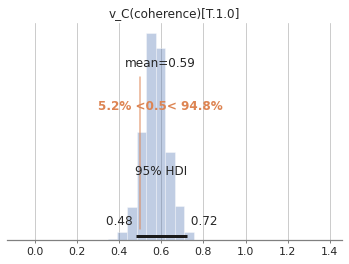

In [64]:
# v_int
az.plot_posterior(InfData_ms1, 
                  filter_vars='regex', 
                  var_names=("^v_(?!.*(subj|std|Intercept))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=0.5)

<AxesSubplot:title={'center':'v_Intercept'}>

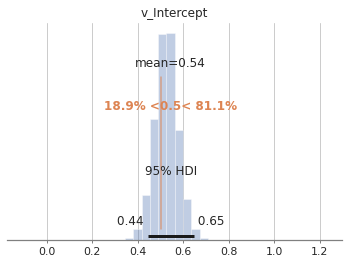

In [65]:
# v_coh
az.plot_posterior(InfData_ms1, 
                  filter_vars='regex', 
                  var_names=("^v_(?!.*(subj|std|coherence))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=0.5)

<AxesSubplot:title={'center':'t_C(attention)[T.1.0]'}>

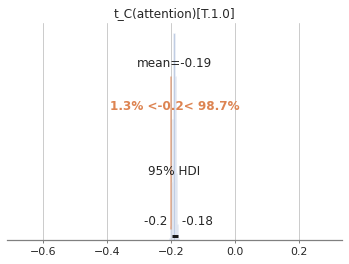

In [70]:
# t_int
az.plot_posterior(InfData_ms1, 
                  filter_vars='regex', 
                  var_names=("^t_(?!.*(subj|std|Intercept))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=-0.2)

<AxesSubplot:title={'center':'t_Intercept'}>

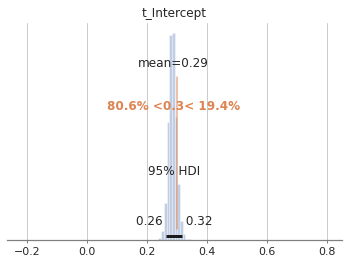

In [71]:
# t_coh
az.plot_posterior(InfData_ms1, 
                  filter_vars='regex', 
                  var_names=("^t_(?!.*(subj|std|attention))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=0.3)

# Simulation3

## simulate the data

In [40]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 15
trials_per_level = 36

# set the group parameter
# intercept and slope of v
v_int = 1
v_coh = 0.5
v_sig1 = 0.2
v_sig2 = 0.1
# intercept and slope of z
z_int = 0.5
z_pri = 0.2
z_sig1 = 0.1
z_sig2 = 0.05
# intercept of a
a_int = 1.4
a_sig = 0.1
# intercept of t
t_int = 0.4
t_sig = 0.1

# set the subject parameter
# v
v_int_subj = np.random.normal(v_int,v_sig1,[n_subjects,2])
v_coh_subj = np.random.normal(v_coh,v_sig2,[n_subjects,2])
# z
z_int_subj = np.random.normal(z_int,z_sig1,[n_subjects,2])
z_pri_subj = np.random.normal(z_pri,z_sig2,[n_subjects,2])
# a
a_int_subj = np.random.normal(a_int,a_sig,[n_subjects,2])
# t
t_int_subj = np.random.normal(t_int,t_sig,[n_subjects,2])

# dataframe
df = pd.DataFrame()
for i in range(n_subjects):
    
    # the different v of two experimental factor 
    v_high  = v_int_subj[i] + v_coh_subj[i]
    v_low = v_int_subj[i]
    # the different t of two experimental factor
    z_yes = z_int_subj[i] + z_pri_subj[i]
    z_no = z_int_subj[i]
    # the default parameter a
    a = a_int_subj[i]
    # the default parameter t
    t = t_int_subj[i]
    
    # set up parameters of DDM for four levels of the stimulus face(1).
    level1_a = {'v':v_high[0], 'a':a[0], 't':t[0], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level2_a = {'v':v_high[0], 'a':a[0], 't':t[0], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}
    level3_a = {'v':v_low[0], 'a':a[0], 't':t[0], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level4_a = {'v':v_low[0], 'a':a[0], 't':t[0], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}

    # set up parameters of DDM for four levels of the stimulus car(0).
    level1_b = {'v':v_high[1], 'a':a[1], 't':t[1], 'z':z_yes[1], 'sv':0, 'sz':0, 'st':0}
    level2_b = {'v':v_high[1], 'a':a[1], 't':t[1], 'z':z_no[1], 'sv':0, 'sz':0, 'st':0}
    level3_b = {'v':v_low[1], 'a':a[1], 't':t[1], 'z':z_yes[1], 'sv':0, 'sz':0, 'st':0}
    level4_b = {'v':v_low[1], 'a':a[1], 't':t[1], 'z':z_no[1], 'sv':0, 'sz':0, 'st':0}

    # generate simulated data
    np.random.seed(123)
    data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                                 'level2':level2_a,
                                                 'level3':level3_a,
                                                 'level4':level4_a},
                                                 size = trials_per_level
                                                  )
    data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                                 'level2':level2_b,
                                                 'level3':level3_b,
                                                 'level4':level4_b},
                                                 size = trials_per_level
                                                 )
    # add column stimulus
    data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
    data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

    # combine the data from two stimulus
    data = data_a.append(data_b,ignore_index=True)
    
    # add subject
    data['subj_idx'] = pd.Series(np.ones((len(data)))*i, index=data.index).astype('int64')

    # add column coherence
    data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
    data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

    # add column spatial priotiziation
    data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
    data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0
    
    df = df.append(data)

In [75]:
# set the random seed
np.random.seed(123)

# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 15
trials_per_level = 36

# set up parameters of DDM for four levels of the stimulus face(1).
level1_a = {'v':1, 'a':1.4, 't':.4, 'z':.7, 'sv':0, 'sz':0, 'st':0}
level2_a = {'v':1, 'a':1.4, 't':.4, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level3_a = {'v':0.5, 'a':1.4, 't':.4, 'z':.7, 'sv':0, 'sz':0, 'st':0}
level4_a = {'v':0.5, 'a':1.4, 't':.4, 'z':.5, 'sv':0, 'sz':0, 'st':0}

# set up parameters of DDM for four levels of the stimulus car(0).
level1_b = {'v':1, 'a':1.4, 't':.4, 'z':.7, 'sv':0, 'sz':0, 'st':0}
level2_b = {'v':1, 'a':1.4, 't':.4, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level3_b = {'v':0.5, 'a':1.4, 't':.4, 'z':.7, 'sv':0, 'sz':0, 'st':0}
level4_b = {'v':0.5, 'a':1.4, 't':.4, 'z':.5, 'sv':0, 'sz':0, 'st':0}

# generate simulated data
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                             'level2':level2_a,
                                             'level3':level3_a,
                                             'level4':level4_a},
                                             size = trials_per_level,
                                             subjs = n_subjects)
data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                             'level2':level2_b,
                                             'level3':level3_b,
                                             'level4':level4_b},
                                             size = trials_per_level,
                                             subjs = n_subjects
)
# add column stimulus
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

# combine the data from two stimulus
data = data_a.append(data_b,ignore_index=True)

# add column coherence
data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0

In [76]:
df=data

In [41]:
# the stimulus coding
df.loc[(df['stimulus']==0)&(df['response']==0),'_response']=1
df.loc[(df['stimulus']==1)&(df['response']==1),'_response']=1
df.loc[(df['stimulus']==0)&(df['response']==1),'_response']=0
df.loc[(df['stimulus']==1)&(df['response']==0),'_response']=0

## check the data

In [42]:
df

,rt,response,subj_idx,condition,stimulus,coherence,attention,_response
0,0.759081,1.0,0,level1,1.0,1.0,1.0,1.0
1,0.585081,1.0,0,level1,1.0,1.0,1.0,1.0
2,0.570081,1.0,0,level1,1.0,1.0,1.0,1.0
3,0.675081,1.0,0,level1,1.0,1.0,1.0,1.0
4,0.777081,1.0,0,level1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
283,1.093623,1.0,14,level4,0.0,0.0,0.0,0.0
284,1.280623,0.0,14,level4,0.0,0.0,0.0,1.0
285,0.989623,1.0,14,level4,0.0,0.0,0.0,0.0
286,1.898623,1.0,14,level4,0.0,0.0,0.0,0.0


In [43]:
df.groupby(['response'])['rt'].agg(['size','mean','std'])

,size,mean,std
response,,,
0.0,459,0.869089,0.380881
1.0,3861,0.715724,0.340203


In [44]:
df.groupby(['_response'])['rt'].agg(['size','mean','std'])

,size,mean,std
_response,,,
0.0,1981,0.746258,0.350099
1.0,2339,0.719960,0.345700


In [45]:
df.groupby(['stimulus','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus response                          
0.0      0.0        319  0.874986  0.350128
         1.0       1841  0.737939  0.340606
1.0      0.0        140  0.855650  0.444165
         1.0       2020  0.695478  0.338652

In [46]:
df.groupby(['coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
coherence response                          
0.0       0.0        331  0.919961  0.410817
          1.0       1829  0.758457  0.401985
1.0       0.0        128  0.737536  0.245846
          1.0       2032  0.677261  0.267207

In [47]:
df.groupby(['attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
attention response                          
0.0       0.0        352  0.862692  0.391311
          1.0       1808  0.802992  0.360896
1.0       0.0        107  0.890133  0.345233
          1.0       2053  0.638870  0.300665

In [48]:
df.groupby(['stimulus','coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherence response                          
0.0      0.0       0.0        221  0.921184  0.374964
                   1.0        859  0.786982  0.410045
         1.0       0.0         98  0.770806  0.259192
                   1.0        982  0.695039  0.258056
1.0      0.0       0.0        110  0.917503  0.476626
                   1.0        970  0.733196  0.393196
         1.0       0.0         30  0.628856  0.154986
                   1.0       1050  0.660634  0.274573

In [49]:
df.groupby(['stimulus','attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus attention response                          
0.0      0.0       0.0        250  0.869405  0.344836
                   1.0        830  0.806108  0.357328
         1.0       0.0         69  0.895210  0.370578
                   1.0       1011  0.681974  0.315585
1.0      0.0       0.0        102  0.846238  0.488467
                   1.0        978  0.800348  0.364059
         1.0       0.0         38  0.880914  0.298209
                   1.0       1042  0.597049  0.279302

In [50]:
df.groupby(['stimulus','coherence','attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherence attention response                          
0.0      0.0       0.0       0.0        161  0.916302  0.373997
                             1.0        379  0.843931  0.415402
                   1.0       0.0         60  0.934285  0.380402
                             1.0        480  0.742015  0.400508
         1.0       0.0       0.0         89  0.784569  0.266173
                             1.0        451  0.774324  0.296738
                   1.0       0.0          9  0.634705  0.110841
                             1.0        531  0.627699  0.196482
1.0      0.0       0.0       0.0         77  0.916826  0.538440
                             1.0        463  0.849267  0.426837
                   1.0       0.0         33  0.919084  0.291971
                             1.0        507  0.627198  0.325785
         1.0       0.0       0.0         25  0.628829  0.144274
                             1.0        515  0.756368  0.289958
                   1.0       0.0          5  0.628987  0.221946
                             1.0        535  0.568479  0.223213

## visualize the data

### the barplot

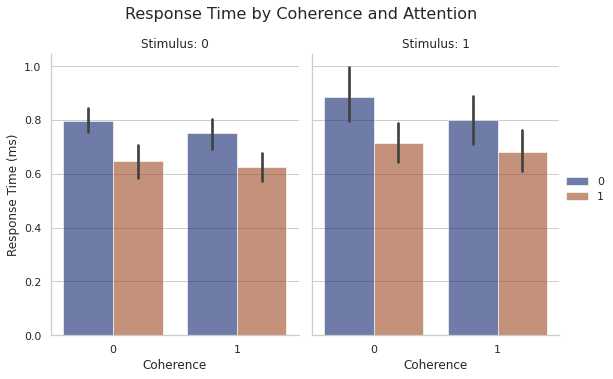

In [77]:
# get the mean of accurate RTs
data_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the figure theme
sns.set_theme(style="whitegrid")
# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

### the raincloud plot 

Text(0.5, 1, 'Response Time by Coherence and Attention')

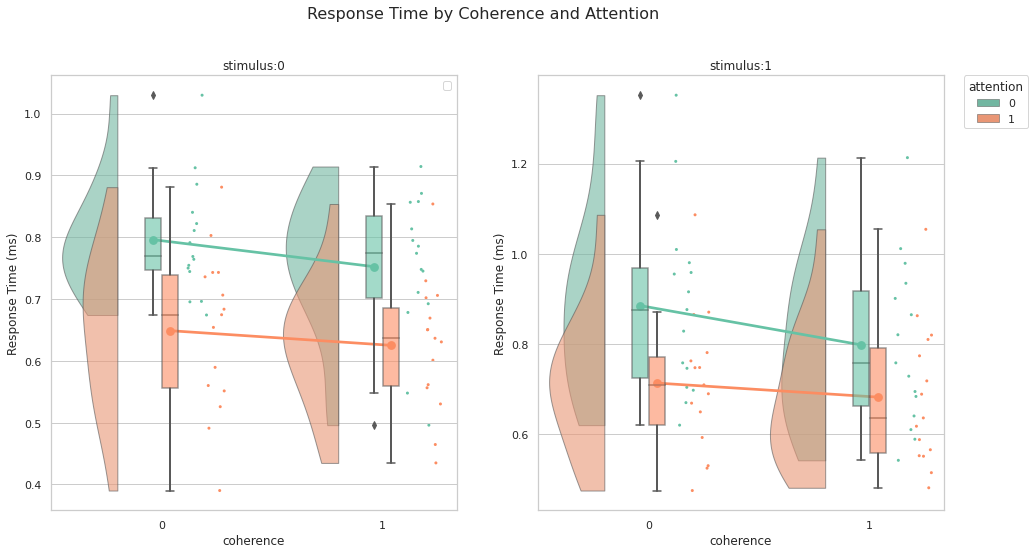

In [78]:
f, ax = plt.subplots(1,2,figsize=(16, 8))
# the left figure
ax[0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0].legend('')
ax[0].set_title('stimulus:0')
ax[0].set_ylabel('Response Time (ms)')
# the right figure
ax[1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1].set_title('stimulus:1')
ax[1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

## ANOVA

In [79]:
# ANOVA for rt
model_aovrm3way = AnovaRM(df,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(df,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                          Anova
                             F Value Num DF  Den DF Pr > F
----------------------------------------------------------
coherence                    25.2988 1.0000 14.0000 0.0002
attention                    52.8094 1.0000 14.0000 0.0000
stimulus                      2.2515 1.0000 14.0000 0.1557
coherence:attention           0.1554 1.0000 14.0000 0.6994
coherence:stimulus            0.6432 1.0000 14.0000 0.4360
attention:stimulus            0.3970 1.0000 14.0000 0.5388
coherence:attention:stimulus  0.0514 1.0000 14.0000 0.8239

                          Anova
                             F Value Num DF  Den DF Pr > F
----------------------------------------------------------
coherence                    62.9750 1.0000 14.0000 0.0000
attention                    94.8047 1.0000 14.0000 0.0000
stimulus                      0.4235 1.0000 14.0000 0.5257
coherence:attention           2.9624 1.0000 14.0000 0.1072
coherence:stimulus            1.0494 1.0000 14.000

## fit data

### define the model

In [27]:
def z_link_func(x, data=df):
        stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                                  {'s': data.stimulus.loc[x.index]},return_type='dataframe'))
        )
        # Apply z = (1 - x) to flip them along 0.5
        z_flip = np.subtract(stim, x.to_frame())
        # The above inverts those values we do not want to flip,
        # so invert them back
        z_flip[stim == 0] *= -1
        return z_flip

In [81]:
 def ms2(id, df=None, samples=None, burn=None, thin=1,save_name='ms1'):
        '''
        id: the id of cpu thread
        df: the input data
        samples: number of samples for MCMC
        burn: number of burn-in of MCMC
        thin: number of thin
        save_name: prefix of file name when saving the model object
        '''
        print('running chain {:d} for model {}'.format(id, save_name))
        # the database file
        dbname = save_name + '_chain_%i.db'%id
        # the model object store here
        mname = save_name + '_chain_%i'%id
        # define the model
        v_reg = {'model':'v~C(coherence)','link_func':lambda x:x}
        z_reg = {'model':'z~C(attention)','link_func':lambda x:x}
        reg_descr = [v_reg, z_reg]
        m = hddm.HDDMRegressor(df, 
                               reg_descr, 
                               include=['z'],
                               group_only_regressors=False,
                               keep_regressor_trace=True
                               )
        # find the starting point
        m.find_starting_values()
        # MCMC sample
        m.sample(samples, 
                 burn=burn, 
                 thin=thin, 
                 dbname=dbname,
                 db='pickle')
        # save
        m.save(mname)
        
        return m

### judge whether need to sample

In [4]:
%%time
# number of chains
chains=4
# file name
file_names = glob.glob('ms2'+'_chain_*[!db]',recursive=False)
# if there exists file, pass
if file_names:
    # sort filename by id
    file_names = sorted(file_names, key = lambda x:x[-1])
    ms2res = []
    for fname in file_names:
        print('current loading:',fname,'\n')
        ms2res.append(hddm.load(fname))
# else sample
else:
    ms2res = Parallel(n_jobs = 4)(delayed(ms2)(id = i, df = df, samples=4000,burn = 2000,thin=2, save_name = 'ms2' ) for i in range(4))


current loading: ms2_chain_0 

current loading: ms2_chain_1 

current loading: ms2_chain_2 

current loading: ms2_chain_3 

CPU times: user 9.88 s, sys: 237 ms, total: 10.1 s
Wall time: 10.2 s


In [84]:
ms2res = Parallel(n_jobs = 4)(delayed(ms2)(id = i, df = df, samples=4000,burn = 2000,thin=2, save_name = 'ms2' ) for i in range(4))

### convert hddm model object to Inferencedata    

In [ ]:
file_names = glob.glob('infdata_ms2_netcdf',recursive=False)
if file_names:
    infdata_ms2 = az.from_netcdf('infdata_ms2_netcdf')
else:
    InfData_ms2 = InferenceDataFromHDDM(ms2res, nppc = 300, save_name="infdata_ms2")

## visualization

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(coherence)[T.1.0]
Plotting v_C(coherence)[T.1.0]_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(attention)[T.1.0]
Plotting z_C(attention)[T.1.0]_std


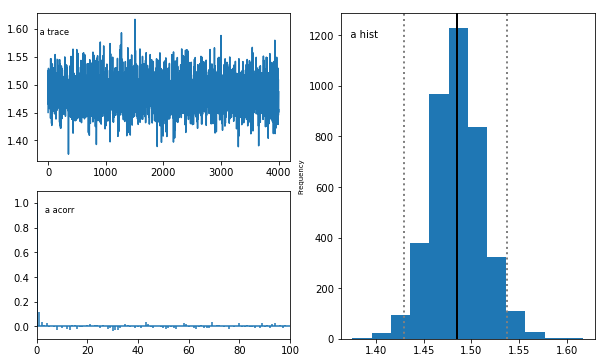

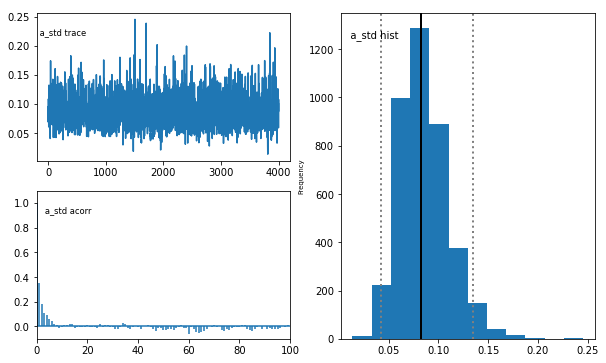

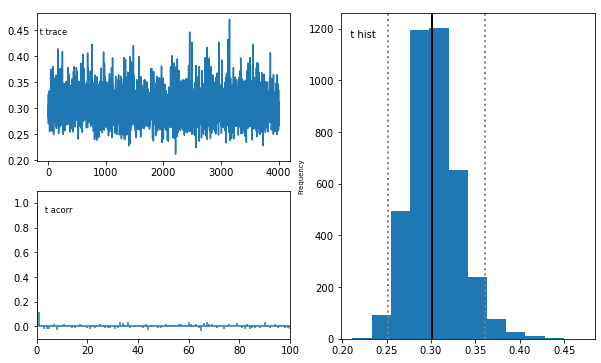

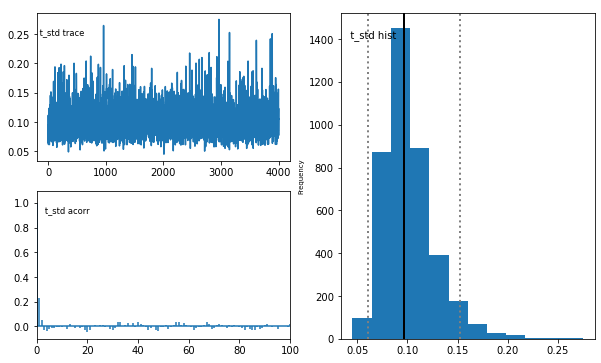

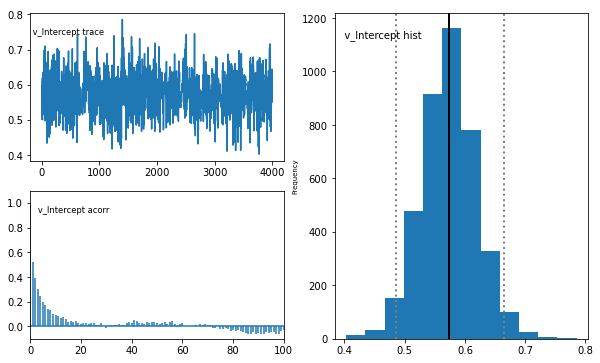

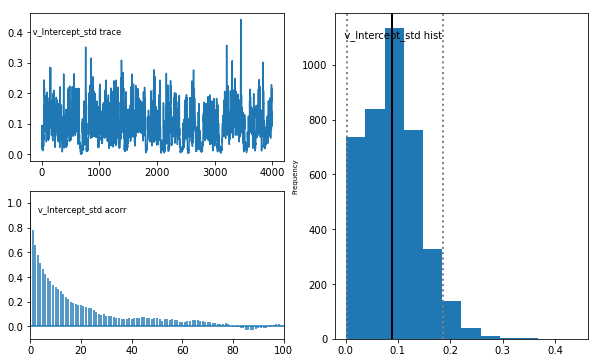

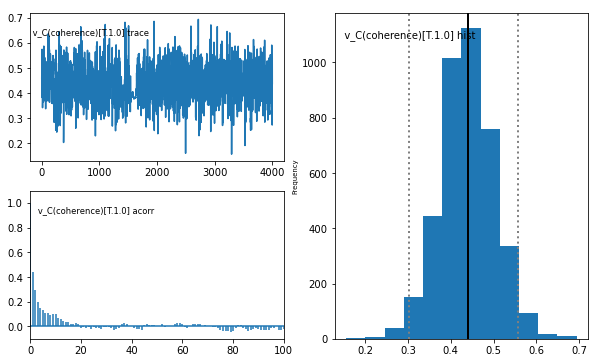

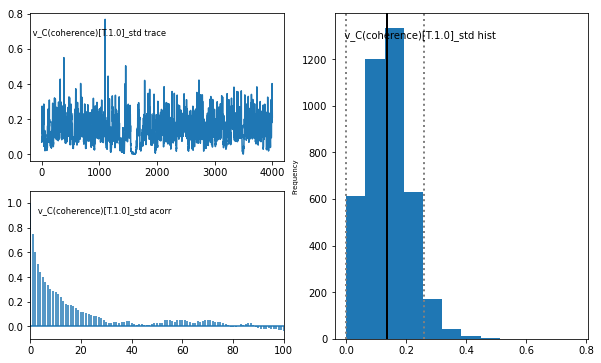

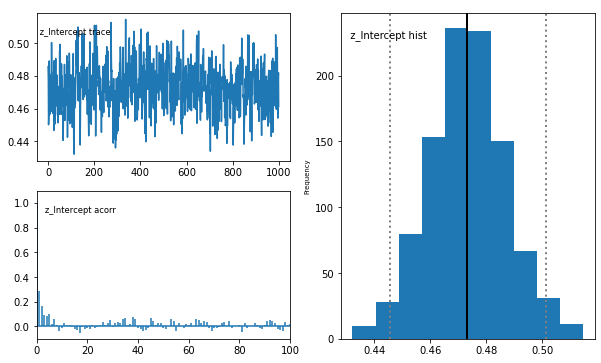

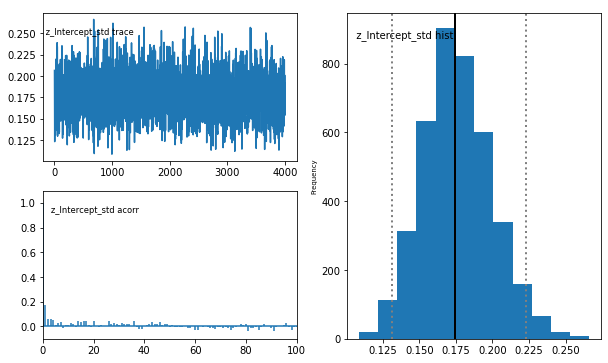

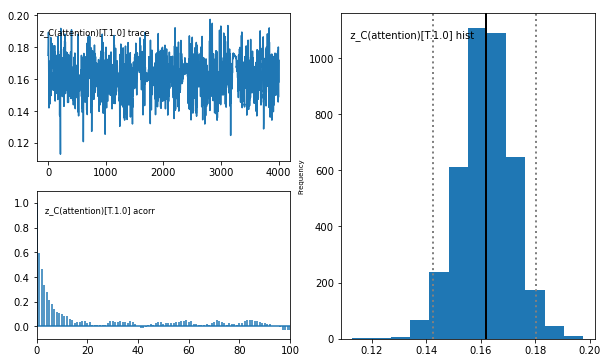

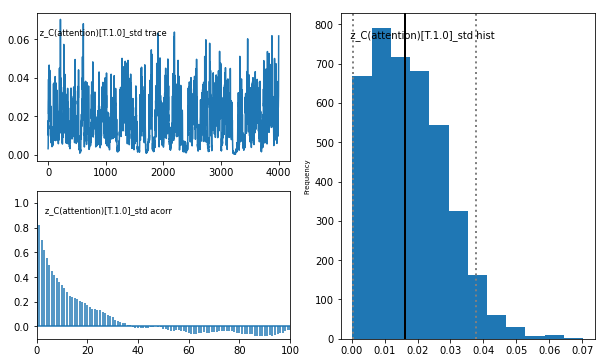

In [5]:
m2 = kabuki.utils.concat_models(ms2res)
m2.plot_posteriors()

In [ ]:
az.plot_trace(InfData_ms2, 
              var_names=("^v(?!.*(subj|std))"), 
              filter_vars='regex')

In [ ]:
az.plot_trace(InfData_ms2, 
              var_names=("^z(?!.*(subj|std))"), 
              filter_vars='regex')

### summary data

In [ ]:
ms2_summary_tmp = az.summary(InfData_ms2, round_to=4)
ms2_summary_tmp.sort_values('r_hat')

In [6]:
m2.print_stats()

                                   mean       std      2.5q       25q       50q       75q     97.5q    mc err
a                              1.485116  0.026917  1.433269  1.467809  1.484822    1.5018  1.541723   0.00049
a_std                          0.085487  0.024843  0.045423  0.067905   0.08272  0.099173  0.142449  0.000653
a_subj.0                       1.432908  0.040126  1.356197   1.40527   1.43294  1.459569  1.512925  0.000744
a_subj.1                       1.453808  0.040801  1.376037  1.426869  1.452534  1.480963  1.536936  0.000622
a_subj.2                       1.576078  0.048387  1.487601  1.542393  1.573321  1.607788  1.678819  0.001048
a_subj.3                       1.574631  0.047841  1.482673  1.542186  1.574161  1.606784  1.672319  0.000995
a_subj.4                       1.463953  0.041176  1.385405  1.436562  1.462665  1.491623  1.546081  0.000793
a_subj.5                       1.531903   0.05221  1.431639  1.496859  1.531544  1.567465  1.633794  0.001246
a_subj.6  

### posterior predictive check

In [ ]:
az.plot_ppc(InfData_ms2,
            var_names=['rt','response'], 
            textsize=20, 
            num_pp_samples=300, 
            alpha = 0.2)

### Check dic, loo and waic

In [3]:
# dic
m2.dic

-1589.737085887929

In [ ]:
# loo
az.loo(InfData_ms2, scale="deviance")

In [ ]:
# waic
az.waic(InfData_ms2, scale="deviance")

### posterior predictive check by condition

In [ ]:
# coherence
plot_ppc_by_cond(data = InfData_ms2, 
                 or_d = df, 
                 subjs = [3], 
                 conds = ['coherence'], 
                 num_pp_samples=300, 
                 random_seed = 7, 
                 alpha = 0.2, 
                 grid = [2,2], 
                 textsize=20, 
                 var_names=['rt'])

In [ ]:
# attention
plot_ppc_by_cond(data = InfData_ms2, 
                 or_d = df, 
                 subjs = [3], 
                 conds = ['attention'], 
                 num_pp_samples=300, 
                 random_seed = 7, 
                 alpha = 0.2, 
                 grid = [2,2], 
                 textsize=20, 
                 var_names=['rt'])

## Statistical Inference

In [ ]:
az.plot_posterior(InfData['ms2'], 
                  filter_vars='regex', 
                  var_names=("^v_(?!.*(subj|std|Intercept))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=v_int)

In [ ]:
az.plot_posterior(InfData['ms2'], 
                  filter_vars='regex', 
                  var_names=("^v_(?!.*(subj|std|coherence))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=v_coh)

In [ ]:
# z_int
az.plot_posterior(InfData['ms2'], 
                  filter_vars='regex', 
                  var_names=("^z_(?!.*(subj|std|Intercept))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=t_int)

In [ ]:
# z_coh
az.plot_posterior(InfData['ms2'], 
                  filter_vars='regex', 
                  var_names=("^z_(?!.*(subj|std|attention))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=t_pri)